![](http://sigdelta.com/assets/images/sages-sd-logo.png)

# Analiza danych i uczenie maszynowe w Python

Autor notebooka: Jakub Nowacki.

## Klasyfikacja

Zadaniem klasyfikacji w uczeniu maszynowym jest przewidzenie dyskretnych klas na podstawie podanych cech. Do zilustrowania działania klasyfikacji wykorzystamy [klasyczny zbiór parametrów irysów](https://en.wikipedia.org/wiki/Iris_flower_data_set). Poniżej wczytujemy dane z dostępnych bibliotek.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, neighbors, svm, tree, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

iris_ds = datasets.load_iris()
print(iris_ds.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

### Zadanie

1. Zamień zbiór na DataFrame `iris` potrzebny do późniejszej klasyfikacji:
    - nazwę kolumn cech pobierz ze listy cech;
    - usuń z nazw kolumn jednostki w nawiasie;
    - zamień spacje w nazwie na podkreślnik _
    - zmienna opisywaną nazwij `iris_class`.

In [3]:
iris_ds.data
iris_ds.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
cols=[c.replace(' (cm)','').replace(' ', '_') for c in iris_ds.feature_names]
cols

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [8]:
iris=pd.DataFrame(iris_ds.data, columns=cols)\
     .assign(iris_class=iris_ds.target)
iris.head()
iris.sepal_length

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
5      5.4
6      4.6
7      5.0
8      4.4
9      4.9
10     5.4
11     4.8
12     4.8
13     4.3
14     5.8
15     5.7
16     5.4
17     5.1
18     5.7
19     5.1
20     5.4
21     5.1
22     4.6
23     5.1
24     4.8
25     5.0
26     5.0
27     5.2
28     5.2
29     4.7
      ... 
120    6.9
121    5.6
122    7.7
123    6.3
124    6.7
125    7.2
126    6.2
127    6.1
128    6.4
129    7.2
130    7.4
131    7.9
132    6.4
133    6.3
134    6.1
135    7.7
136    6.3
137    6.4
138    6.0
139    6.9
140    6.7
141    6.9
142    5.8
143    6.8
144    6.7
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal_length, Length: 150, dtype: float64

Użyjemy funkcji `train_test_split` do podziału zbioru na treningowy i testowy.

In [9]:
iris_train, iris_test = train_test_split(iris, test_size=0.2) # podzial losowy;zwraca  krotke; jest mozliwosc ustawienia seed poprez dodanie w argumentach random_state=np. 42

In [10]:
iris_train.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_class
14,5.8,4.0,1.2,0.2,0
105,7.6,3.0,6.6,2.1,2
21,5.1,3.7,1.5,0.4,0
90,5.5,2.6,4.4,1.2,1
49,5.0,3.3,1.4,0.2,0


In [11]:
iris_test.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_class
123,6.3,2.7,4.9,1.8,2
107,7.3,2.9,6.3,1.8,2
98,5.1,2.5,3.0,1.1,1
101,5.8,2.7,5.1,1.9,2
139,6.9,3.1,5.4,2.1,2


In [12]:
iris.size, iris_train.size, iris_test.size

(750, 600, 150)

## Regresja logistyczna

Jednym z najprostszych modeli klasyfikacji jest [regresja logistyczna](https://en.wikipedia.org/wiki/Logistic_regression). 

![](https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg)

Model ten wykonuje klasyfikację z użyciem funkcji sigmoidalnej do przewidzenia jednej z dwóch klas. W przypadku wielu klas wykorzystuje się wiele funkcji sigmoidalnych.

In [13]:
features = ['sepal_length', 'sepal_width']

logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], logreg.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.50      0.62      0.56         8
          2       0.73      0.62      0.67        13

avg / total       0.75      0.73      0.74        30



array([[-3.18662725,  5.23703159],
       [ 1.12657622, -2.61273996],
       [ 2.06005104, -2.62429162]])

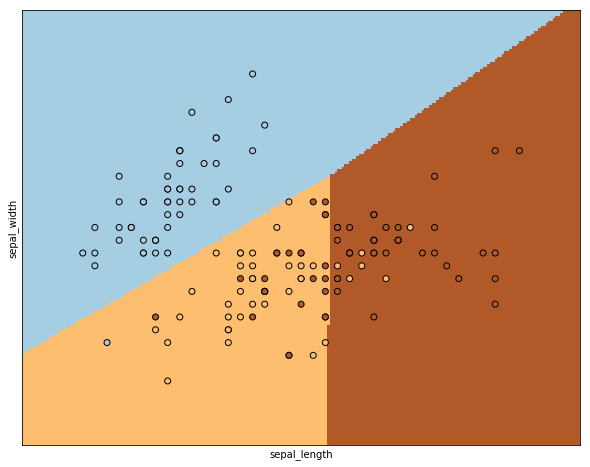

In [23]:
def plot_decision_area(df, features, model, target='iris_class'):

    if len(features) > 2:
        raise ValueError('Too many features, works only with 2')
    
    h = .02  # step size in the mesh

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, y_min = tuple(df[features].min() - .5)
    x_max, y_max = tuple(df[features].max() + .5)

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(df[features[0]], df[features[1]], c=df[target], edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel(features[0])
    plt.ylabel(features[1])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

plot_decision_area(iris, features, logreg)
logreg.coef_

### Zadanie 

1. Spróbuj zmienić parametr `multi_class` i `solver`; zobacz [dokumentacje](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), żeby poznać dostępne opcję; co się zmieniło?
1. Dodaj inne cechy i zobacz jak to wpływa na jakość klasyfikacji?

In [22]:
features = ['sepal_length', 'sepal_width']

logreg = linear_model.LogisticRegression(C=1e5, multi_class='multinomial',solver='saga')

logreg.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], logreg.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.50      0.75      0.60         8
          2       0.78      0.54      0.64        13

avg / total       0.77      0.73      0.74        30



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Support Vector Machines Classifier

Jak wspomniano w poprzednim notebooku odnośnie SVM, są też klasyfikatory używające funkcji jądrowych.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_iris_0012.png)

Zacznijmy od klasyfikatora liniowego.

In [24]:
features = ['sepal_length', 'sepal_width']

svc = svm.LinearSVC()

svc.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], svc.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.50      0.62      0.56         8
          2       0.73      0.62      0.67        13

avg / total       0.75      0.73      0.74        30



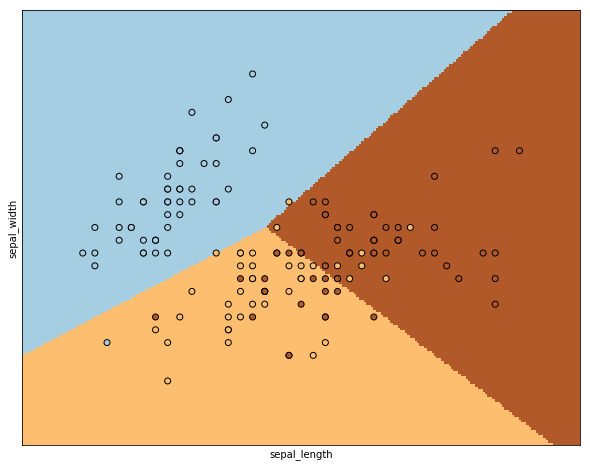

In [25]:
plot_decision_area(iris, features, svc)

### Zadanie 

1. Spróbuj zmienić parametr `multi_class`; zobacz [dokumentacje](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) żeby poznać dostępne opcję; co się zmieniło?
1. Spróbuj zmienić parametr `loss`; co się zmieniło?
1. Dodaj inne cechy i zobacz jak to wpływa na jakość klasyfikacji?
1. Zastosuj SVC z inną funkcją jądrową; zobacz [dokumentację](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). **Uwaga!** Wykres działa tylko dla klasyfikacji dwuwymiarowej,

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.60      0.75      0.67         8
          2       0.82      0.69      0.75        13

avg / total       0.81      0.80      0.80        30



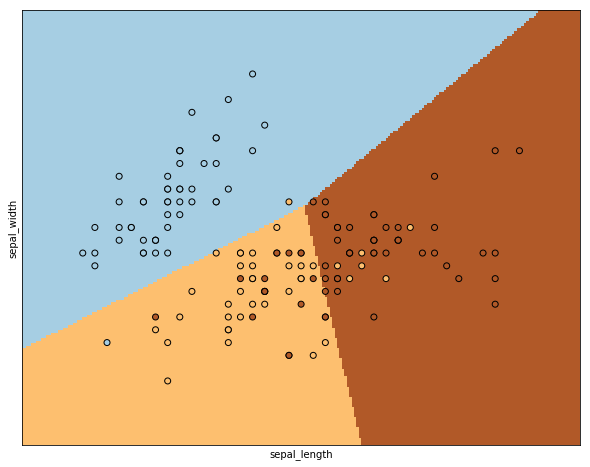

In [45]:
features = ['sepal_length', 'sepal_width']

svc2 = svm.LinearSVC(multi_class='crammer_singer')
svc3 = svm.LinearSVC(loss='hinge')
svc4 = svm.SVC(kernel='poly')


svc2.fit(iris_train[features], iris_train['iris_class'])
svc3.fit(iris_train[features], iris_train['iris_class'])
svc4.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], svc2.predict(iris_test[features])))
plot_decision_area(iris, features, svc2)



             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       0.62      0.62      0.62         8
          2       0.83      0.77      0.80        13

avg / total       0.80      0.80      0.80        30



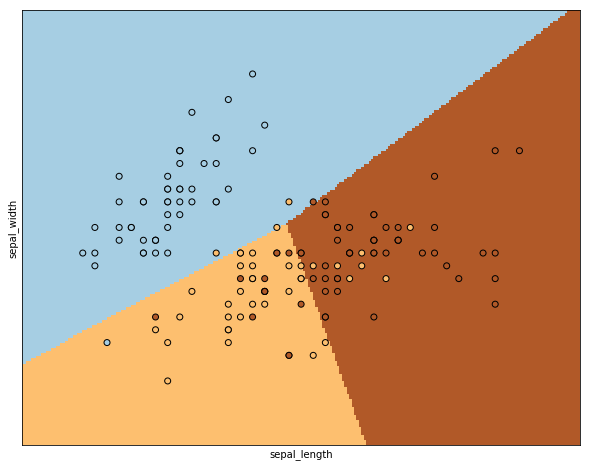

In [42]:
print(classification_report(iris_test['iris_class'], svc3.predict(iris_test[features])))
plot_decision_area(iris, features, svc3)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.55      0.75      0.63         8
          2       0.80      0.62      0.70        13

avg / total       0.79      0.77      0.77        30



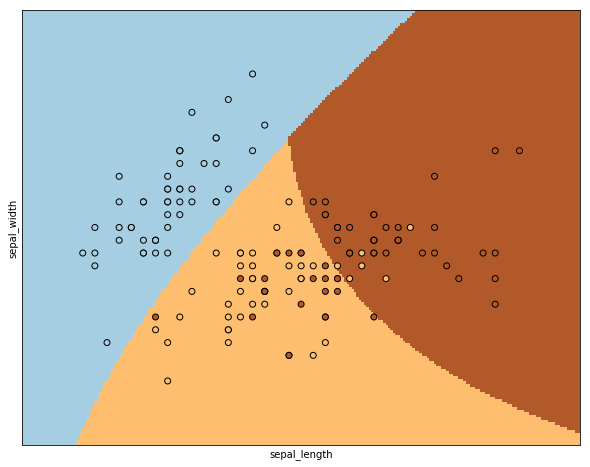

In [46]:
print(classification_report(iris_test['iris_class'], svc4.predict(iris_test[features])))
plot_decision_area(iris, features, svc4)

## K-Nearest Neighbors

[K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to bardzo prosty algorytm klasyfikujący. Nie ma on funkcji klasyfikacyjnej jako takie, ale zapisuje zbiór uczący i podejmuje decyzję o klasie nowego elementu na podstawie *k* wybranych najbliższych elementów; zobacz poniższą ilustrację.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/279px-KnnClassification.svg.png)

Dla *k=3* nowy element (trójkąt) będzie sklasyfikowany jako czerwony, ale już dla *k=5*, będzie on sklasyfikowany jako niebieski.

Poniżej przedstawiamy działanie algorytmu na przykładowym zbiorze danych.

In [48]:
features = ['sepal_length', 'sepal_width']

knn = neighbors.KNeighborsClassifier()

knn.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], knn.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.50      0.75      0.60         8
          2       0.78      0.54      0.64        13

avg / total       0.77      0.73      0.74        30



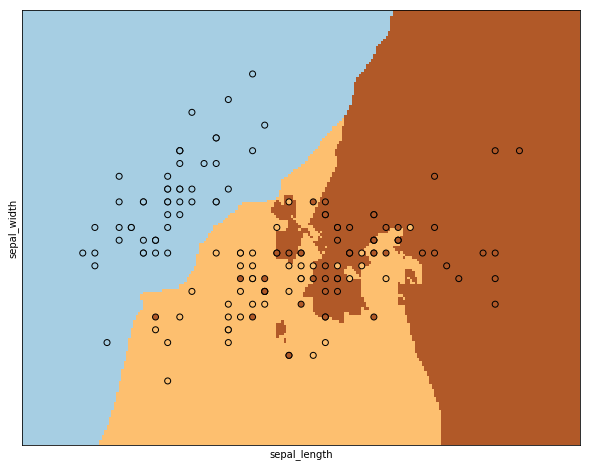

In [50]:
plot_decision_area(iris, features, knn)

### Zadanie

1. Zmień parametr `weights`; zobacz [dokumentację](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier); co się zmieniło?
1. Zmień parametr `n_neighbors`; co się zmieniło?
1. Dodaj inne cechy i zobacz jak to wpływa na jakość klasyfikacji?

In [47]:
features = ['sepal_length', 'sepal_width']

knn2 = neighbors.KNeighborsClassifier( weights='distance')

knn2.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], knn2.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.44      0.88      0.58         8
          2       0.80      0.31      0.44        13

avg / total       0.76      0.67      0.65        30



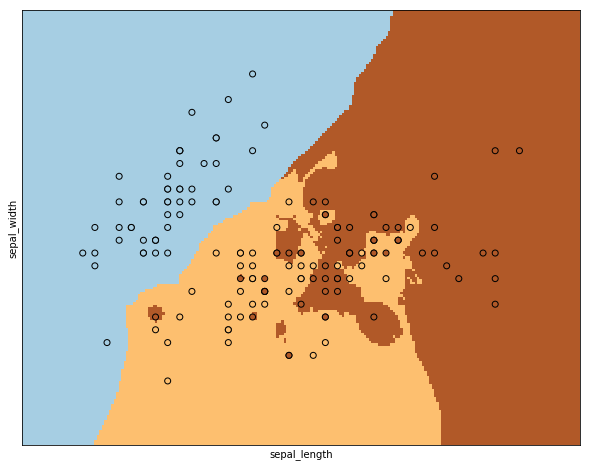

In [49]:
plot_decision_area(iris, features, knn2)

In [77]:
features = ['sepal_length', 'sepal_width']

knn3 = neighbors.KNeighborsClassifier( weights='distance',n_neighbors=7)

knn3.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], knn3.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.44      0.88      0.58         8
          2       0.80      0.31      0.44        13

avg / total       0.76      0.67      0.65        30



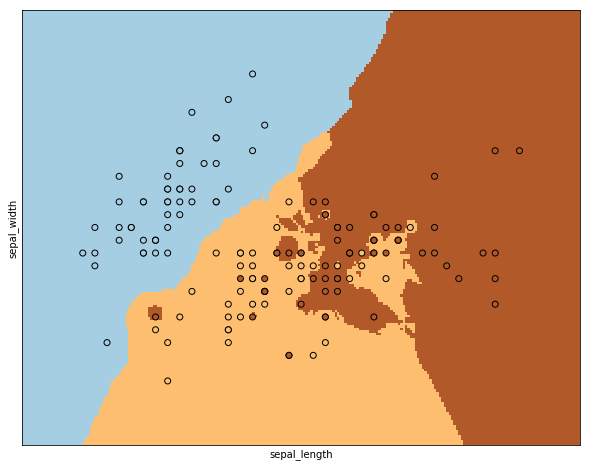

In [78]:
plot_decision_area(iris, features, knn3)

## Drzewa decyzyjne

Kolejnym typem klasifikatorów są [drzewa decyzyjne](https://en.wikipedia.org/wiki/Decision_tree). Takie klasyfikatory składają się z drzewa, który nauczony jest podejmować decyzje w zależności od wartości parametrów. 

![](https://upload.wikimedia.org/wikipedia/commons/c/c6/Manual_decision_tree.jpg)

Zastosujmy drzewo decyzyjne do naszego zbioru danych.

In [79]:
features = ['sepal_length', 'sepal_width']

dtc = tree.DecisionTreeClassifier()

dtc.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], dtc.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.44      0.88      0.58         8
          2       0.80      0.31      0.44        13

avg / total       0.76      0.67      0.65        30



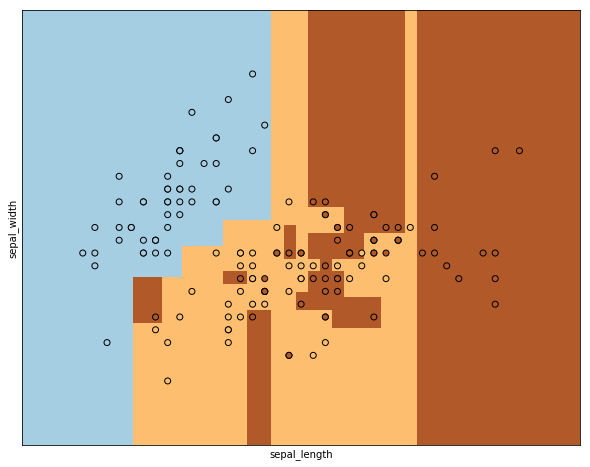

In [80]:
plot_decision_area(iris, features, dtc)

In [81]:
import graphviz

dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=features,  
                         class_names=iris_ds.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data, )  
graph

ModuleNotFoundError: No module named 'graphviz'

### Zadanie

1. Zmień parametr `criterion`; zobacz [dokumentację](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html); co się zmieniło?
1. Zmień parametr `splitter`; co się zmieniło?
1. Dodaj inne cechy i zobacz jak to wpływa na jakość klasyfikacji?

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.44      0.88      0.58         8
          2       0.80      0.31      0.44        13

avg / total       0.76      0.67      0.65        30



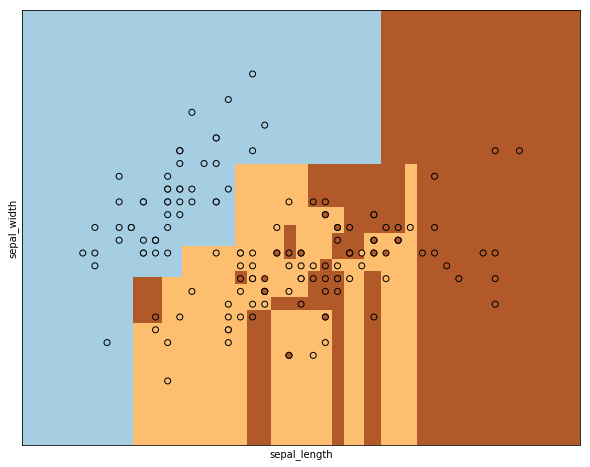

In [83]:
features = ['sepal_length', 'sepal_width']

dtc2 = tree.DecisionTreeClassifier(criterion='entropy')

dtc2.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], dtc2.predict(iris_test[features])))
plot_decision_area(iris, features, dtc2)

             precision    recall  f1-score   support

          0       1.00      0.89      0.94         9
          1       0.37      0.88      0.52         8
          2       0.67      0.15      0.25        13

avg / total       0.69      0.57      0.53        30



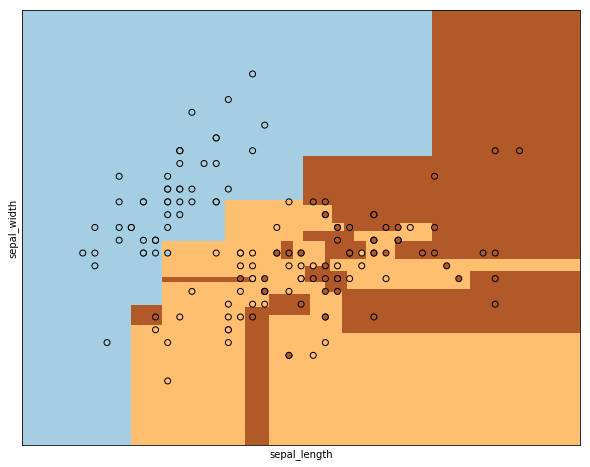

In [85]:
features = ['sepal_length', 'sepal_width']

dtc3 = tree.DecisionTreeClassifier(splitter='random')

dtc3.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], dtc3.predict(iris_test[features])))
plot_decision_area(iris, features, dtc3)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.44      0.88      0.58         8
          2       0.80      0.31      0.44        13

avg / total       0.76      0.67      0.65        30



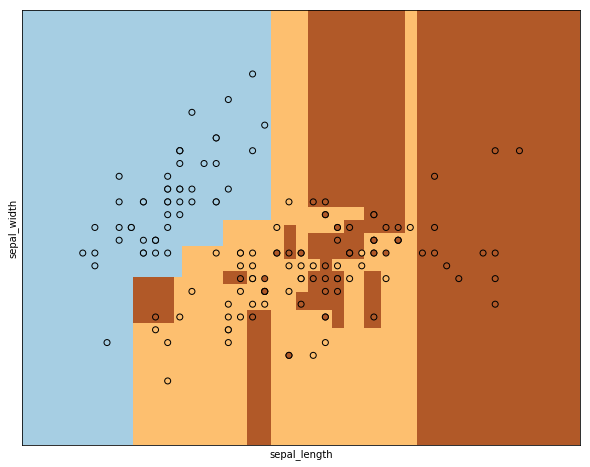

In [89]:
features = ['sepal_length', 'sepal_width']

dtc4= tree.DecisionTreeClassifier(max_depth=20)

dtc4.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], dtc4.predict(iris_test[features])))
plot_decision_area(iris, features, dtc4)

## Kalibracja parametrów modeli

Wiele powyższych modeli ma wiele parametrów, które mogą wpłynąć na jakość klasyfikacji. Dotychczas skupialiśmy się na zmianach algorytmów lub cech. Spróbujmy teraz znaleźć najlepszy model. Wykorzystamy do tego celu funkcję [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).

Najpierw definiujemy przestrzeń parametrów do przeszukania.

In [90]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

Następnie uczymy model podobnie jak poprzednio ale z użyciem `GridSearchCV`.

In [94]:
features = ['sepal_length', 'sepal_width']

svc = GridSearchCV(svm.SVC(probability=True), param_grid, return_train_score=True)    

svc.fit(iris_train[features], iris_train['iris_class'])

print(classification_report(iris_test['iris_class'], svc.predict(iris_test[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.55      0.75      0.63         8
          2       0.80      0.62      0.70        13

avg / total       0.79      0.77      0.77        30



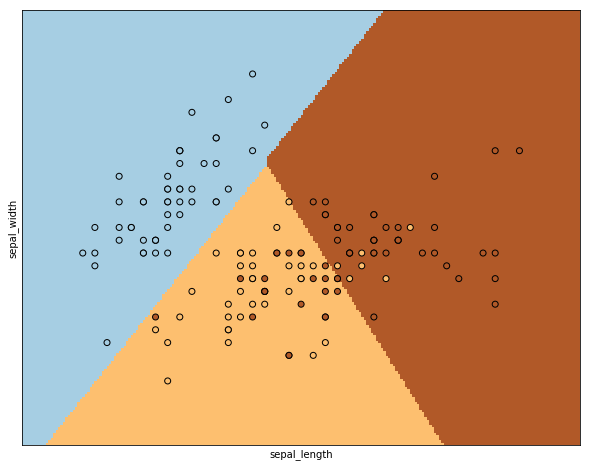

In [92]:
plot_decision_area(iris, features, svc) 

### Zadanie

1. Jaki model wygrał?
1. Zmień inne parametry modelu SVC i zobacz ich wpływ.
1. Zobacz czy dodanie cech poprawia jakość klasyfikacji.
1. Wykonaj kalibrację dla regresji logistycznej.
1. Wykonaj kalibrację dla k-NN.

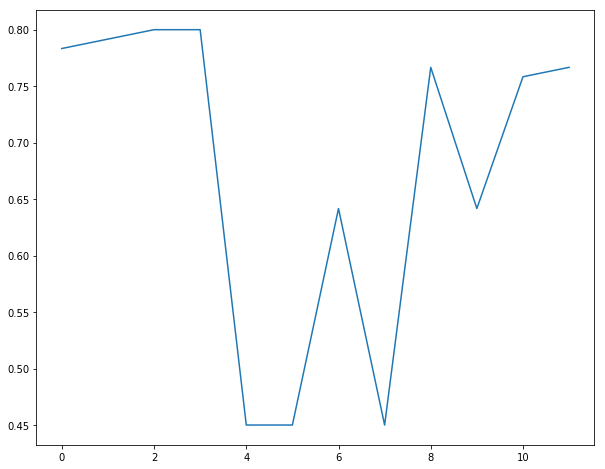

In [99]:
svc.best_estimator_
svc.cv_results_
pd.DataFrame(svc.cv_results_).mean_test_score.plot()

In [103]:
cv=pd.DataFrame(svc.cv_results_)
cv['rank_test_score']

0      4
1      3
2      1
3      1
4     10
5     10
6      8
7     10
8      5
9      8
10     7
11     5
Name: rank_test_score, dtype: int32

## Ocena jakości modelu

Aby ocenić jak dobrze model klasyfikuje, czy przeprowadza regresję, używamy wielu metryk, które mają za zadanie skupić się na poszczególnych parametrach modelu. Podstawowym testem który używaliśmy jest funkcja `classification_report`:

In [104]:
y_true = iris_test['iris_class']
y_pred = svc.predict(iris_test[features])

print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.55      0.75      0.63         8
          2       0.80      0.62      0.70        13

avg / total       0.79      0.77      0.77        30



Funkcja ta prezentuje prezentuje precyzję i dokładność ([precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)) w wersji wieloklasowej. Możemy też policzyć te parametry osobno jako średnie:

In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score

avg = 'macro'
print('Precision: {:.4f}'.format(precision_score(y_true, y_pred, average=avg)))
print('Recall: {:.4f}'.format(recall_score(y_true, y_pred, average=avg)))
print('F1: {:.4f}'.format(f1_score(y_true, y_pred, average=avg)))

Precision: 0.7818
Recall: 0.7885
F1: 0.7757


Lub dla każdej klasy jak w raporcie:

In [106]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
precision, recall, f1, support

(array([1.        , 0.54545455, 0.8       ]),
 array([1.        , 0.75      , 0.61538462]),
 array([1.        , 0.63157895, 0.69565217]),
 array([ 9,  8, 13], dtype=int64))

Parametry powyższe liczone są na macierzy pomyłek ([confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)), w tym przypadku w wersji wieloklasowej. Możemy otrzymać numeryczną wersję tej macierzy używając funkcji `confusion_matrix`:

In [107]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[9, 0, 0],
       [0, 6, 2],
       [0, 5, 8]], dtype=int64)

W formie graficznej:

Confusion matrix, without normalization
[[9 0 0]
 [0 6 2]
 [0 5 8]]


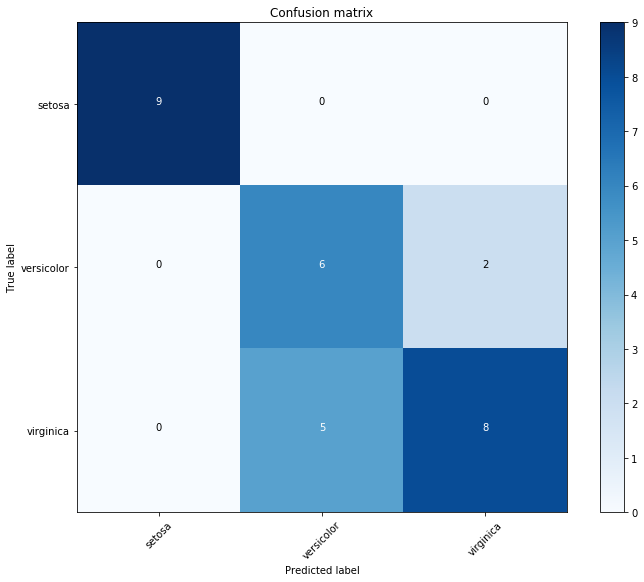

In [108]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, iris_ds.target_names)

Są też inne rodzaje metryk o których można poczytać w [dokumentacji](http://scikit-learn.org/stable/modules/model_evaluation.html). Przykładowo, jest też prosta [miara Jaccarda], która opiera się na podobieństwie zbiorów:

In [ ]:
from sklearn.metrics import jaccard_similarity_score

jaccard_similarity_score(y_true, y_pred)

Inną popularną metryką jest krzywa ROC ([Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)). Krzywa ta mówi o jakości klasyfikacji jako poziom rozdzielenia dwóch klas od siebie.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/709px-ROC_curves.svg.png)

Jako wartość metryki stosuje się powierzchnię pod krzywą (Area Under the Curve, AUC). 

Wprawdzie metrykę stosuje się dla klasyfikacji binarnej, można ją policzyć dla każdej klasy i uśrednić, jak pokazano poniżej; wieloklasowy przykład na podstawie [dokumentacji](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

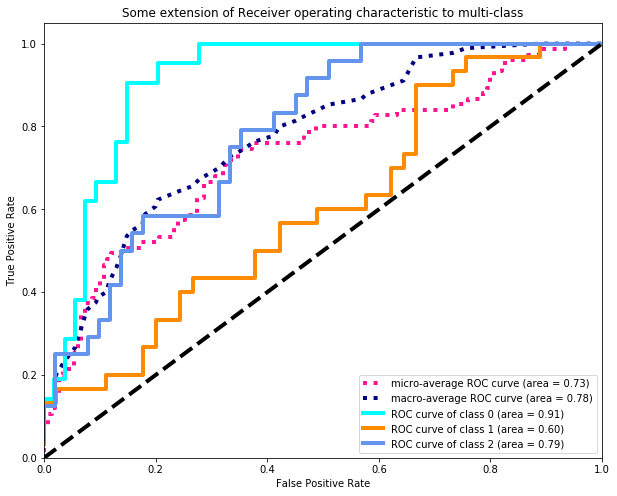

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()